# Summary statistics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import genetools
import seaborn as sns

sns.set_style("dark")

In [2]:
import pandas as pd

In [3]:
from slugify import slugify

In [4]:
import dask
import dask.dataframe as dd

In [5]:
import os

In [6]:
from malid import config

In [7]:
from malid import helpers

In [8]:
import genetools

In [9]:
from malid.datamodels import GeneLocus

In [10]:
from malid import io

### Load

Raise worker connection timeouts (see other dask notebooks):

In [11]:
import distributed

# These only seem to be picked up by scheduler, not by individual workers

dask.config.set(
    {
        "distributed.comm.timeouts.tcp": "120s",
        "distributed.comm.timeouts.connect": "120s",
        "distributed.comm.retry.count": 5,
    }
)

In [12]:
# These will be picked up by individual workers

with open(os.path.expandvars("$HOME/.config/dask/distributed.yaml"), "w") as w:
    w.write(
        """distributed:
  comm:
    retry:
      count: 5
    timeouts:
      connect: 120s          # time before connecting fails
      tcp: 120s              # time before calling an unresponsive connection dead
    """
    )

In [13]:
from dask.distributed import Client

# multi-processing backend
# if already opened from another notebook, see https://stackoverflow.com/questions/60115736/dask-how-to-connect-to-running-cluster-scheduler-and-access-total-occupancy
client = Client(
    scheduler_port=config.dask_scheduler_port,
    dashboard_address=config.dask_dashboard_address,
    n_workers=config.dask_n_workers,
    processes=True,
    threads_per_worker=8,
    memory_limit="auto",
    worker_dashboard_address=":0",  # start worker dashboards on random ports
)
display(client)
# for debugging: client.restart()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:61093/status,
Dashboard: http://127.0.0.1:61093/status,Workers: 8
Total threads: 64,Total memory: 251.88 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61094,Workers: 8
Dashboard: http://127.0.0.1:61093/status,Total threads: 64
Started: Just now,Total memory: 251.88 GiB
Comm: tcp://127.0.0.1:43717,Total threads: 8
Dashboard: http://127.0.0.1:36087/status,Memory: 31.48 GiB
Nanny: tcp://127.0.0.1:41739,


In [14]:
# Filter to specimens that are kept in the training set and have all gene loci available
metadata = helpers.get_all_specimen_info()
specimen_labels = list(
    metadata[
        (metadata["in_training_set"])
        & (metadata["available_gene_loci"] == config.gene_loci_used)
    ]["specimen_label"].unique()
)
filters = [("specimen_label", "in", list(specimen_labels))]
len(specimen_labels)

550

In [15]:
desired_cols = [
    "specimen_label",
    "disease",
    "isotype_supergroup",
    "cdr3_aa_sequence_trim_len",
    "v_mut",
    "igh_or_tcrb_clone_id",
]

In [16]:
# Don't use fastparquet, because it changes specimen labels like M54-049 to 2049-01-01 00:00:54 -- i.e. it coerces partition names to numbers or dates
df = dd.read_parquet(
    config.paths.sequences_sampled,
    columns=desired_cols,
    filters=filters,
    engine="pyarrow",
)
df

{"message": "/home/maxim/miniconda/envs/cuda-env-py39/lib/python3.9/site-packages/distributed/worker.py:3031: UserWarning: Large object of size 1.04 MiB detected in task graph: \n  ([<pyarrow.dataset.ParquetFileFragment path=/home/ ... mp_unit=ns>>}})\nConsider scattering large objects ahead of time\nwith client.scatter to reduce scheduler burden and \nkeep data on workers\n\n    future = client.submit(func, big_data)    # bad\n\n    big_future = client.scatter(big_data)     # good\n    future = client.submit(func, big_future)  # good\n  warnings.warn(\n", "time": "2024-08-16T18:14:20.163944"}


,specimen_label,disease,isotype_supergroup,cdr3_aa_sequence_trim_len,v_mut,igh_or_tcrb_clone_id
npartitions=550,,,,,,
,category[known],category[unknown],category[unknown],int64,float64,int64
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


In [17]:
# Mark which sequences are BCR vs TCR
df["gene_locus"] = (df["isotype_supergroup"] == "TCRB").map(
    {True: GeneLocus.TCR.name, False: GeneLocus.BCR.name}
)
df

,specimen_label,disease,isotype_supergroup,cdr3_aa_sequence_trim_len,v_mut,igh_or_tcrb_clone_id,gene_locus
npartitions=550,,,,,,,
,category[known],category[unknown],category[unknown],int64,float64,int64,object
,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


### Calculate

In [18]:
%%time
# Coverage: Number of clones per sample
# (BCR: count each clone once, even if we keep several copies of it in different isotypes)
num_clones_per_sample = df.map_partitions(
    lambda part: part.groupby(
        ["specimen_label", "disease", "gene_locus"],
        observed=True,
    )["igh_or_tcrb_clone_id"]
    .nunique()
    .rename("num_clones_per_specimen")
).compute()
num_clones_per_sample.head()

CPU times: user 2.71 s, sys: 408 ms, total: 3.12 s
Wall time: 8.34 s


specimen_label  disease             gene_locus
M124-S014       Healthy/Background  BCR           24549
                                    TCR           42108
M111-S037       HIV                 BCR           24689
                                    TCR           48755
M111-S033       HIV                 BCR           22182
Name: num_clones_per_specimen, dtype: int64

In [19]:
# One entry per specimen x gene locus
num_clones_per_sample.shape

(1100,)

## Plot

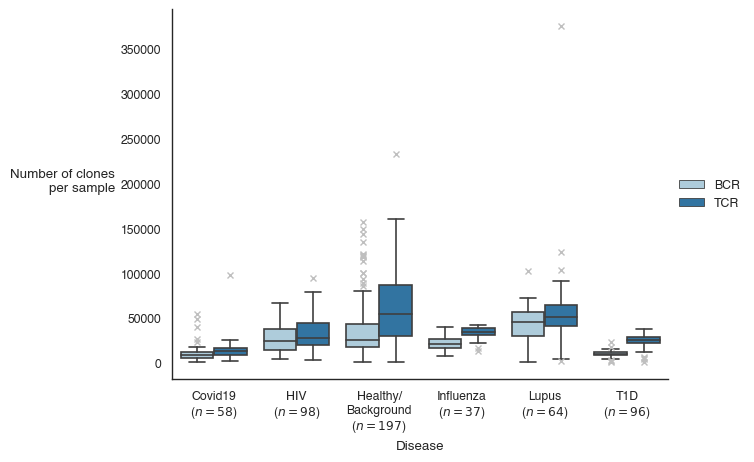

In [20]:
with sns.axes_style("white"), sns.plotting_context("paper"):
    ax = sns.boxplot(
        data=num_clones_per_sample.reset_index(),
        x="disease",
        hue="gene_locus",
        y="num_clones_per_specimen",
        flierprops=dict(
            markerfacecolor="0.75",
            markersize=5,
            linestyle="none",
            #
            marker="x",
            markeredgecolor="0.75",
        ),
        order=list(sorted(num_clones_per_sample.reset_index()["disease"].unique())),
        palette=sns.color_palette("Paired")[:2],
    )
    ax.set_xticklabels(
        genetools.plots.add_sample_size_to_labels(
            ax.get_xticklabels(),
            # Don't double count specimens across gene loci
            num_clones_per_sample.reset_index().groupby("specimen_label").first(),
            "disease",
        )
    )
    genetools.plots.wrap_tick_labels(ax, wrap_amount=10, wrap_y_axis=False)
    sns.despine(ax=ax)
    sns.move_legend(
        ax, "center left", bbox_to_anchor=(1, 0.5), title=None, frameon=False
    )
    plt.xlabel("Disease")
    plt.ylabel("Number of clones\nper sample", rotation=0, ha="right")
    genetools.plots.savefig(
        ax.get_figure(),
        config.paths.base_output_dir_for_selected_cross_validation_strategy
        / "repertoire_summary_stats.num_clones_per_specimen_by_disease.png",
        dpi=300,
    )

In [21]:
# Example of how the raw data looks:

In [22]:
io.load_raw_parquet_sequences_for_specimens(
    specimen_labels=[specimen_labels[0]],
    gene_locus=GeneLocus.BCR,
    fname=config.paths.sequences,
).iloc[0].to_dict()

{'participant_age': '27',
 'participant_description': 'Location: USA',
 'specimen_time_point': None,
 'amplification_locus': 'IgH',
 'amplification_template': 'cDNA',
 'amplification_label': 'M124-S014_cDNA_PCR',
 'replicate_label': 'M124-S014_cDNA_PCR_IGA',
 'run_label': 'M124',
 'trimmed_sequence': 'TGTAGTCTCTGGATTCACCTTTAGTAACTATGCCATGAACTGGGTCCGCCAGGCTCCAGGCAAGGGGCTAGAGTGGGTCTCAGCTATGAGTGCTACTAGTGGTAGCACATACTACGCAGACTCCGTGAAGGGCCGGTTCACCATCTCCAGAGACAATTCCAAGAGCACGTTGTATCTGCAAATGGACCGCCTGAGAGCCGAGGACACGGCCTTATATTACTGTGCGAAAGATGAACGCAGCTCGTCTGACTCCTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAGCATCCCCGACCAGCCCCAAGGTCTTCCCGCTGAGCCTCGACAGCACCCCCCAAGATGGGAACGTGGTCGTCGCA',
 'v_segment': 'IGHV3-23*01',
 'j_segment': 'IGHJ4*02',
 'v_score': 311.0,
 'productive': True,
 'fr1_seq_aa_q': '  V  V  S ',
 'cdr1_seq_aa_q': ' G  F  T  F  S  N  Y  A ',
 'fr2_seq_aa_q': ' M  N  W  V  R  Q  A  P  G  K  G  L  E  W  V  S  A ',
 'cdr2_seq_aa_q': ' M  S  A  T  S  G  S  T ',
 'fr3_seq_aa_q': ' Y  Y  A  D  S  V  K  G  

In [33]:
io.load_raw_parquet_sequences_for_specimens(
    specimen_labels=[specimen_labels[0]],
    gene_locus=GeneLocus.TCR,
    fname=config.paths.sequences,
).iloc[0].to_dict()

{'participant_age': '27',
 'participant_description': 'Location: USA',
 'specimen_time_point': None,
 'amplification_locus': 'TCRB',
 'amplification_template': 'cDNA',
 'amplification_label': 'M125-S014_cDNA_PCR_TCRB',
 'replicate_label': 'M125-S014_cDNA_PCR_TCRB_R1',
 'run_label': 'M125',
 'trimmed_sequence': 'TCTGCAGAAAGGCCTGGGAGATCCGTCTCCACTCTGAAGATCCAGCGCACACAGCAGGAGGACTCCGCCGTGTATCTCTGTGCCAGCAGTTATAGCCCCCTGGGGGCAGGGTCCAATCAGCCCCAGCATTTTGGTGATGGGACTCGACTCTCCATCCTAGAGGACCTGAACAAG',
 'v_segment': 'TRBV7-8*01',
 'j_segment': 'TRBJ1-5*01',
 'v_score': 131.0,
 'productive': True,
 'fr1_seq_aa_q': 'GAGVSQSPRYKVAKRGQDVALRCDPI',
 'cdr1_seq_aa_q': 'SGHVS',
 'fr2_seq_aa_q': 'LFWYQQALGQGPEFLTY',
 'cdr2_seq_aa_q': 'FQNEAQ',
 'fr3_seq_aa_q': 'LDKSGLPSDRFFAERPEGSVSTLKIQRTQQEDSAVYLC',
 'cdr3_seq_aa_q': ' A  S  S  Y  S  P  L  G  A  G  S  N  Q  P  Q  H ',
 'post_seq_aa_q': ' F  G  D  G  T  R  L  S  I  L  ',
 'v_sequence': 'tgcagaaaggcctgGgAgatccgtctccactctgaagatccagcgcacacagcaggaggactccgccgtgtatctc

# Also look at pre-sampling data

In [23]:
desired_cols = [
    "isotype_supergroup",
    "trimmed_sequence",
]

In [24]:
# Don't use fastparquet, because it changes specimen labels like M54-049 to 2049-01-01 00:00:54 -- i.e. it coerces partition names to numbers or dates
df = dd.read_parquet(
    config.paths.sequences,  # not sequences_sampled
    columns=desired_cols,
    filters=filters,
    engine="pyarrow",
)
df

,isotype_supergroup,trimmed_sequence
npartitions=550,,
,category[unknown],object
,...,...
...,...,...
,...,...
,...,...


In [25]:
# Mark which sequences are BCR vs TCR
df["gene_locus"] = (df["isotype_supergroup"] == "TCRB").map(
    {True: GeneLocus.TCR.name, False: GeneLocus.BCR.name}
)
df

,isotype_supergroup,trimmed_sequence,gene_locus
npartitions=550,,,
,category[unknown],object,object
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [29]:
%%time
# Nucleotide length
df["sequence_length"] = df["trimmed_sequence"].str.len()
sequence_lengths = df.groupby(["gene_locus"])["sequence_length"].mean().compute()
sequence_lengths

CPU times: user 5.18 s, sys: 2.02 s, total: 7.2 s
Wall time: 1min 37s


gene_locus
BCR    339.034752
TCR    145.518725
Name: sequence_length, dtype: float64

In [31]:
df.groupby(["gene_locus"])["sequence_length"].median().compute()

{"message": "Task exception was never retrieved\nfuture: <Task finished name='Task-180667' coro=<Client._gather.<locals>.wait() done, defined at /home/maxim/miniconda/envs/cuda-env-py39/lib/python3.9/site-packages/distributed/client.py:2173> exception=AllExit()>", "time": "2024-08-16T18:22:40.092177", "exc_info": "Traceback (most recent call last):\n  File \"/home/maxim/miniconda/envs/cuda-env-py39/lib/python3.9/site-packages/distributed/client.py\", line 2182, in wait\n    raise AllExit()\ndistributed.client.AllExit"}


gene_locus
BCR    333.0
TCR    144.0
Name: sequence_length, dtype: float64

In [30]:
# Clean up
client.shutdown()

{"message": "Batched Comm Closed <TCP (closed) Scheduler connection to worker local=tcp://127.0.0.1:61094 remote=tcp://127.0.0.1:49792>", "time": "2024-08-01T01:11:05.652457", "exc_info": "Traceback (most recent call last):\n  File \"/home/maxim/miniconda/envs/cuda-env-py39/lib/python3.9/site-packages/distributed/batched.py\", line 115, in _background_send\n    nbytes = yield coro\n  File \"/home/maxim/miniconda/envs/cuda-env-py39/lib/python3.9/site-packages/tornado/gen.py\", line 767, in run\n    value = future.result()\n  File \"/home/maxim/miniconda/envs/cuda-env-py39/lib/python3.9/site-packages/distributed/comm/tcp.py\", line 269, in write\n    raise CommClosedError()\ndistributed.comm.core.CommClosedError"}
